# COGS 108 - EDA Checkpoint

# Names

- Adory Vo
- Andrew Park
- Royce Labuguen
- Schuyler Voss

<a id='research_question'></a>
# Research Question

Do weather conditions have a notable effect on the performance of Major League Baseball players? How are stats such as hits, runs, home runs, pitch velocity, and errors affected when players are put in weather conditions that are more extreme than they are used to?

# Setup

In [1]:
# Import datasets from Shared Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Function to retrieve file path from Google Drive
def drive_path(filename):
  return f'/content/drive/Shareddrives/COGS 108 - Group 031 Project/{filename}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import essential libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 7)

# Data Cleaning

## 2016 MLB Season

We chose data from 2016 MLB season games to track weather conditions for. Additionally, we are specifically examining the Rays and White Sox, so we want to filter out the weather conditions from their games.

In [3]:
season = pd.read_csv(drive_path('2016-mlb-season.csv'))
print("Shape:", season.shape)
season.head()

Shape: (2463, 26)


,Unnamed: 0,attendance,away_team,away_team_errors,away_team_hits,away_team_runs,date,field_type,game_type,home_team,...,temperature,wind_speed,wind_direction,sky,total_runs,game_hours_dec,season,home_team_win,home_team_loss,home_team_outcome
0,0,40030.0,New York Mets,1,7,3,2016-04-03,on grass,Night Game,Kansas City Royals,...,74.0,14.0,from Right to Left,Sunny,7,3.216667,regular season,1,0,Win
1,1,21621.0,Philadelphia Phillies,0,5,2,2016-04-06,on grass,Night Game,Cincinnati Reds,...,55.0,24.0,from Right to Left,Overcast,5,2.383333,regular season,1,0,Win
2,2,12622.0,Minnesota Twins,0,5,2,2016-04-06,on grass,Night Game,Baltimore Orioles,...,48.0,7.0,out to Leftfield,Unknown,6,3.183333,regular season,1,0,Win
3,3,18531.0,Washington Nationals,0,8,3,2016-04-06,on grass,Night Game,Atlanta Braves,...,65.0,10.0,from Right to Left,Cloudy,4,2.883333,regular season,0,1,Loss
4,4,18572.0,Colorado Rockies,1,8,4,2016-04-06,on grass,Day Game,Arizona Diamondbacks,...,77.0,0.0,in unknown direction,In Dome,7,2.650000,regular season,0,1,Loss


First, let's look at the columns and decide which ones we want.

In [4]:
season.columns

Index(['Unnamed: 0', 'attendance', 'away_team', 'away_team_errors',
       'away_team_hits', 'away_team_runs', 'date', 'field_type', 'game_type',
       'home_team', 'home_team_errors', 'home_team_hits', 'home_team_runs',
       'start_time', 'venue', 'day_of_week', 'temperature', 'wind_speed',
       'wind_direction', 'sky', 'total_runs', 'game_hours_dec', 'season',
       'home_team_win', 'home_team_loss', 'home_team_outcome'],
      dtype='object')

### Filtering to our desired columns
For each baseball game, there are a subset of columns that are the most helpful for our analysis as well as some other columns that do not provide any useful information. Of course, we would like to know the home and away teams playing, as well as each of these teams' amount of hits, errors, total runs during the game, as well as which team ended up winning. Also, since our research question revolves around finding the relationship between weather conditions and the overall performance of baseball teams, we include the temperature during the game, the overall weather description (sunny, overcast, rain, etc.), and the overall wind speed/direction throughout the game. Additionally, we are including the attendance column to cross-reference games with our other dataset (more later).

So, let's filter out these columns from our dataset.

In [5]:
def filter_cols(df):
  """Filters columns from the dataset and returns a new dataframe."""
  GAME_COLS = ['sky', 'temperature', 'wind_speed', 'wind_direction']
  HOME_COLS = ['home_team', 'home_team_hits', 'home_team_errors', 'home_team_runs', 'home_team_win']
  AWAY_COLS = ['away_team', 'away_team_hits', 'away_team_errors', 'away_team_runs']
  
  DESIRED_COLS = GAME_COLS + HOME_COLS + AWAY_COLS + ['attendance']

  new_df = df[DESIRED_COLS]

  return new_df

season = filter_cols(season)

Next, let's examine the values of these columns to make sure they are usable.  

In [6]:
season['away_team_hits'].unique()   # returns ints
season['home_team_win'].unique()    # returns 0 for a loss and 1 for a win
season['sky'].unique()              # returns strings: "Sunny, Overcast, Unknown, Cloudy, In Dome, Drizzle, Rain, Night"
season['temperature'].unique()      # returns floats
season['wind_speed'].unique()       # returns floats
season['wind_direction'].unique()   # returns strings describing direction relative to the field

array([' from Right to Left', ' out to Leftfield',
       ' in unknown direction', ' from Left to Right',
       ' out to Rightfield', ' in from Leftfield', ' in from Rightfield',
       ' out to Centerfield', ' in from Centerfield'], dtype=object)

### Making sure each row in our dataframe contains useful information
Looking at each unique value that could be stored in each of our columns, most of the columns contain either strings (team that is playing) or ints/floats for weather and baseball statistics. However, the 'sky' column contains a value 'Unknown'. We believe that rows where the 'sky' column contains 'Unknown' do not provide us with any useful information, since we are describing the overall relationship between weather and performance. Thus, we'll remove rows which contain this specific column's value.

Additionally, we can rename the wind direction values to be simpler - "from Right to Left" -> "RtoL" for example.

In [7]:
def clean_values(df):
  """Cleans values from the dataset and returns a new dataframe."""
  # Removing rows with sky == 'Unknown'
  new_df = df[df['sky'] != 'Unknown'].copy()

  # Function to rename a wind direction value
  def rename(value):
    """Renames a wind direction value."""
    # Trim whitespace
    value = value.strip()

    # Rename terms
    value = value.replace('from', '')
    value = value.replace('out', '')
    value = value.replace('field', '')
    value = value.replace('Left', 'L')
    value = value.replace('Center', 'C')
    value = value.replace('Right', 'R')
    value = value.replace('in', 'from')
    value = value.replace('from unknown direction', 'NA')

    # Remove spaces
    value = value.replace(' ', '')

    return value
  
  # Renaming all wind direction values
  new_df['wind_direction'] = new_df['wind_direction'].map(rename)

  return new_df

season = clean_values(season)
print("Sky Values:", season['sky'].unique())
print("Wind Direction Values:", season['wind_direction'].unique())

Sky Values: ['Sunny' 'Overcast' 'Cloudy' 'In Dome' 'Drizzle' 'Rain' 'Night']
Wind Direction Values: ['RtoL' 'NA' 'toL' 'toR' 'LtoR' 'fromL' 'fromR' 'toC' 'fromC']


Finally, we can use the `away_team` and `home_team` columns to find our desired games!

In [8]:
TEAM_NAMES = ['Tampa Bay Rays', 'Chicago White Sox']
home_games = season[season['home_team'].isin(TEAM_NAMES)]
away_games = season[season['away_team'].isin(TEAM_NAMES)]

team_games = pd.concat([home_games, away_games])
team_games = team_games.reset_index(drop=True)
team_games.head()

,sky,temperature,wind_speed,wind_direction,home_team,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team,away_team_hits,away_team_errors,away_team_runs,attendance
0,In Dome,72.0,0.0,NA,Tampa Bay Rays,7,1,3,1,Toronto Blue Jays,9,0,2,12757.0
1,In Dome,72.0,0.0,NA,Tampa Bay Rays,8,0,3,1,Chicago White Sox,5,1,2,21810.0
2,In Dome,72.0,0.0,NA,Tampa Bay Rays,5,0,2,1,Baltimore Orioles,5,0,0,12996.0
3,In Dome,72.0,0.0,NA,Tampa Bay Rays,4,1,1,0,Toronto Blue Jays,5,0,5,27217.0
4,Sunny,60.0,16.0,LtoR,Chicago White Sox,13,0,7,1,Minnesota Twins,4,0,2,28049.0


**Final cleaning code:**

In [9]:
season = pd.read_csv(drive_path('2016-mlb-season.csv'))

def filter_cols(df):
  """Filters columns from the dataset and returns a new dataframe."""
  GAME_COLS = ['sky', 'temperature', 'wind_speed', 'wind_direction']
  HOME_COLS = ['home_team', 'home_team_hits', 'home_team_errors', 'home_team_runs', 'home_team_win']
  AWAY_COLS = ['away_team', 'away_team_hits', 'away_team_errors', 'away_team_runs']
  
  DESIRED_COLS = GAME_COLS + HOME_COLS + AWAY_COLS + ['attendance']

  new_df = df[DESIRED_COLS]

  return new_df

def clean_values(df):
  """Cleans values from the dataset and returns a new dataframe."""
  # Removing rows with sky == 'Unknown'
  new_df = df[df['sky'] != 'Unknown'].copy()

  # Function to rename a wind direction value
  def rename(value):
    """Renames a wind direction value."""
    # Trim whitespace
    value = value.strip()

    # Rename terms
    value = value.replace('from', '')
    value = value.replace('out', '')
    value = value.replace('field', '')
    value = value.replace('Left', 'L')
    value = value.replace('Center', 'C')
    value = value.replace('Right', 'R')
    value = value.replace('in', 'from')
    value = value.replace('from unknown direction', 'NA')

    # Remove spaces
    value = value.replace(' ', '')

    return value
  
  # Renaming all wind direction values
  new_df['wind_direction'] = new_df['wind_direction'].map(rename)

  return new_df

season = filter_cols(season)
season = clean_values(season)

In [10]:
TEAM_NAMES = ['Tampa Bay Rays', 'Chicago White Sox']
home_games = season[season['home_team'].isin(TEAM_NAMES)]
away_games = season[season['away_team'].isin(TEAM_NAMES)]

team_games = pd.concat([home_games, away_games])
team_games = team_games.reset_index(drop=True)
team_games.head()

,sky,temperature,wind_speed,wind_direction,home_team,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team,away_team_hits,away_team_errors,away_team_runs,attendance
0,In Dome,72.0,0.0,NA,Tampa Bay Rays,7,1,3,1,Toronto Blue Jays,9,0,2,12757.0
1,In Dome,72.0,0.0,NA,Tampa Bay Rays,8,0,3,1,Chicago White Sox,5,1,2,21810.0
2,In Dome,72.0,0.0,NA,Tampa Bay Rays,5,0,2,1,Baltimore Orioles,5,0,0,12996.0
3,In Dome,72.0,0.0,NA,Tampa Bay Rays,4,1,1,0,Toronto Blue Jays,5,0,5,27217.0
4,Sunny,60.0,16.0,LtoR,Chicago White Sox,13,0,7,1,Minnesota Twins,4,0,2,28049.0


## Rays & White Sox Games

To approach our research question, we chose to examine the Rays from Tampa Bay (Florida) and the White Sox from Chicago (Illinois). The White Sox should be more used to cold and inclement weather, so they are like a control group while the Rays will be a variable group that we expect to perform differently under harsh conditions.

To start, we downloaded play-by-play data from Rays games and White Sox games as CSV files using this code in a Kaggle notebook.
```py
# Retrieve dataset from Kaggle database
import bq_helper
baseball = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="baseball")

# Select and download Rays games
rays_games_query = "SELECT * FROM `bigquery-public-data.baseball.games_wide` WHERE awayTeamName='Rays' or homeTeamName='Rays'"
rays_games = baseball.query_to_pandas_safe(rays_games_query, max_gb_scanned=2)
rays_games.to_csv('rays-games.csv', index=False)

# Select and download White Sox games
white_sox_games_query = "SELECT * FROM `bigquery-public-data.baseball.games_wide` WHERE awayTeamName='White Sox' or homeTeamName='White Sox'"
white_sox_games = baseball.query_to_pandas_safe(white_sox_games_query, max_gb_scanned=2)
white_sox_games.to_csv('white-sox-games.csv', index=False)

```

These files were then saved in a shared Google Drive to be easily imported from in Google Colab.

In [11]:
GAMES_FILE_NAMES = ['2016-rays-games-2022-10-23.csv', '2016-white-sox-games-2022-10-23.csv']

Now, we may examine the raw data from these datasets.

In [12]:
def raw_games():
  """Returns dataframes from the datasets' raw data."""
  final_dfs = []
  for filename in GAMES_FILE_NAMES:
    df = pd.read_csv(drive_path(filename), dtype={'awayFielder12': str, 'homeFielder12': str})

    final_dfs.append(df)
  
  return final_dfs

In [13]:
# Get raw data
rays, white_sox = raw_games()

In [14]:
print("Rays, White Sox Shapes:", [rays.shape, white_sox.shape])
rays.head()

Rays, White Sox Shapes: [(50240, 145), (50260, 145)]


,gameId,seasonId,seasonType,year,startTime,gameStatus,attendance,dayNight,duration,durationMinutes,...,homeBatter4,homeBatter5,homeBatter6,homeBatter7,homeBatter8,homeBatter9,lineupTeamId,lineupPlayerId,lineupPosition,lineupOrder
0,0de78e2b-70a7-4f86-b736-fb0daa18b5a5,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-06-02 00:15:00+00:00,closed,30554,N,2:45,165,...,6ef878e2-1f2d-4855-a250-2ec7c97f961c,d4afcfdc-b875-4163-ad7f-eb26b7228f80,03fe9527-5071-4ae1-b521-0a222e41e581,fc1463b4-7507-4d8b-87c4-0df02b99675e,d36e1643-ef4d-48d6-b898-d8654bc7f9e1,f7deada3-d11e-490e-8658-ae83b7612014,NaN,NaN,0,0
1,0de78e2b-70a7-4f86-b736-fb0daa18b5a5,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-06-02 00:15:00+00:00,closed,30554,N,2:45,165,...,6ef878e2-1f2d-4855-a250-2ec7c97f961c,d4afcfdc-b875-4163-ad7f-eb26b7228f80,03fe9527-5071-4ae1-b521-0a222e41e581,fc1463b4-7507-4d8b-87c4-0df02b99675e,d36e1643-ef4d-48d6-b898-d8654bc7f9e1,f7deada3-d11e-490e-8658-ae83b7612014,NaN,NaN,0,0
2,0de78e2b-70a7-4f86-b736-fb0daa18b5a5,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-06-02 00:15:00+00:00,closed,30554,N,2:45,165,...,6ef878e2-1f2d-4855-a250-2ec7c97f961c,d4afcfdc-b875-4163-ad7f-eb26b7228f80,03fe9527-5071-4ae1-b521-0a222e41e581,fc1463b4-7507-4d8b-87c4-0df02b99675e,d36e1643-ef4d-48d6-b898-d8654bc7f9e1,f7deada3-d11e-490e-8658-ae83b7612014,NaN,NaN,0,0
3,0de78e2b-70a7-4f86-b736-fb0daa18b5a5,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-06-02 00:15:00+00:00,closed,30554,N,2:45,165,...,6ef878e2-1f2d-4855-a250-2ec7c97f961c,d4afcfdc-b875-4163-ad7f-eb26b7228f80,03fe9527-5071-4ae1-b521-0a222e41e581,fc1463b4-7507-4d8b-87c4-0df02b99675e,d36e1643-ef4d-48d6-b898-d8654bc7f9e1,f7deada3-d11e-490e-8658-ae83b7612014,NaN,NaN,0,0
4,0de78e2b-70a7-4f86-b736-fb0daa18b5a5,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-06-02 00:15:00+00:00,closed,30554,N,2:45,165,...,6ef878e2-1f2d-4855-a250-2ec7c97f961c,d4afcfdc-b875-4163-ad7f-eb26b7228f80,03fe9527-5071-4ae1-b521-0a222e41e581,fc1463b4-7507-4d8b-87c4-0df02b99675e,d36e1643-ef4d-48d6-b898-d8654bc7f9e1,f7deada3-d11e-490e-8658-ae83b7612014,NaN,NaN,0,0


There are around 50,000 rows of play-by-play data for each team's games - each row represents a play in a game.  
Also, we have 145 columns - we definitely want to filter out the ones we want now.

In [15]:
rays.columns.values.tolist()

['gameId',
 'seasonId',
 'seasonType',
 'year',
 'startTime',
 'gameStatus',
 'attendance',
 'dayNight',
 'duration',
 'durationMinutes',
 'awayTeamId',
 'awayTeamName',
 'homeTeamId',
 'homeTeamName',
 'venueId',
 'venueName',
 'venueSurface',
 'venueCapacity',
 'venueCity',
 'venueState',
 'venueZip',
 'venueMarket',
 'venueOutfieldDistances',
 'homeFinalRuns',
 'homeFinalHits',
 'homeFinalErrors',
 'awayFinalRuns',
 'awayFinalHits',
 'awayFinalErrors',
 'homeFinalRunsForInning',
 'awayFinalRunsForInning',
 'inningNumber',
 'inningHalf',
 'inningEventType',
 'inningHalfEventSequenceNumber',
 'description',
 'atBatEventType',
 'atBatEventSequenceNumber',
 'createdAt',
 'updatedAt',
 'status',
 'outcomeId',
 'outcomeDescription',
 'hitterId',
 'hitterLastName',
 'hitterFirstName',
 'hitterWeight',
 'hitterHeight',
 'hitterBatHand',
 'pitcherId',
 'pitcherFirstName',
 'pitcherLastName',
 'pitcherThrowHand',
 'pitchType',
 'pitchTypeDescription',
 'pitchSpeed',
 'pitchZone',
 'pitcherPit

We want specific columns about the game, play, venue, and some other properties. We don't need things like venueZip or all of the extraneous fielders and batters.  

Furthermore, we want our data to include information that we can use to match play data to the corresponding games from our 2016 MLB Season dataset. We can use the `attendance` column to do this. From this, let us create a new column `index` that references the index of the corresponding game in the other dataset.

In [16]:
# Setup for adding index column
attendance_map = {} # attendance : index
for index, row in team_games.iterrows():
  if np.isnan(row.attendance):
    continue

  key = int(row.attendance)
  value = index
  attendance_map[key] = value

# Add index column
rays = rays.replace({'attendance': attendance_map})
rays = rays.rename(columns={"attendance": "index"})
rays.loc[rays['index'] > 268, 'index'] = np.nan
rays = rays.dropna(subset=['index'])
rays = rays.astype({'index': 'int32'})

rays.tail()

,gameId,seasonId,seasonType,year,startTime,gameStatus,index,dayNight,duration,durationMinutes,...,homeBatter4,homeBatter5,homeBatter6,homeBatter7,homeBatter8,homeBatter9,lineupTeamId,lineupPlayerId,lineupPosition,lineupOrder
50235,f3655f56-4c29-4d8b-932c-7379c73f4417,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-05-11 19:40:00+00:00,closed,246,D,4:01,241,...,01eaff59-9b34-47fd-af64-54b2e6f22628,483d3c01-a089-407d-baaf-c7bfabd56587,f24cc289-a6e2-4c24-9161-fc8a7a27c6b7,36edf276-6c47-43aa-931c-ca4fd10e1025,e39fe9ea-bc67-442e-a178-50a5c0a81b9d,d60c2736-9e57-4c6f-829b-67c1c9e583d3,NaN,NaN,0,0
50236,f3655f56-4c29-4d8b-932c-7379c73f4417,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-05-11 19:40:00+00:00,closed,246,D,4:01,241,...,01eaff59-9b34-47fd-af64-54b2e6f22628,483d3c01-a089-407d-baaf-c7bfabd56587,f24cc289-a6e2-4c24-9161-fc8a7a27c6b7,36edf276-6c47-43aa-931c-ca4fd10e1025,e39fe9ea-bc67-442e-a178-50a5c0a81b9d,d60c2736-9e57-4c6f-829b-67c1c9e583d3,NaN,NaN,0,0
50237,f3655f56-4c29-4d8b-932c-7379c73f4417,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-05-11 19:40:00+00:00,closed,246,D,4:01,241,...,01eaff59-9b34-47fd-af64-54b2e6f22628,483d3c01-a089-407d-baaf-c7bfabd56587,f24cc289-a6e2-4c24-9161-fc8a7a27c6b7,36edf276-6c47-43aa-931c-ca4fd10e1025,e39fe9ea-bc67-442e-a178-50a5c0a81b9d,d60c2736-9e57-4c6f-829b-67c1c9e583d3,NaN,NaN,0,0
50238,f3655f56-4c29-4d8b-932c-7379c73f4417,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-05-11 19:40:00+00:00,closed,246,D,4:01,241,...,01eaff59-9b34-47fd-af64-54b2e6f22628,483d3c01-a089-407d-baaf-c7bfabd56587,f24cc289-a6e2-4c24-9161-fc8a7a27c6b7,36edf276-6c47-43aa-931c-ca4fd10e1025,e39fe9ea-bc67-442e-a178-50a5c0a81b9d,d60c2736-9e57-4c6f-829b-67c1c9e583d3,NaN,NaN,0,0
50239,f3655f56-4c29-4d8b-932c-7379c73f4417,565de4be-dc80-4849-a7e1-54bc79156cc8,REG,2016,2016-05-11 19:40:00+00:00,closed,246,D,4:01,241,...,01eaff59-9b34-47fd-af64-54b2e6f22628,483d3c01-a089-407d-baaf-c7bfabd56587,f24cc289-a6e2-4c24-9161-fc8a7a27c6b7,36edf276-6c47-43aa-931c-ca4fd10e1025,e39fe9ea-bc67-442e-a178-50a5c0a81b9d,d60c2736-9e57-4c6f-829b-67c1c9e583d3,NaN,NaN,0,0


Finally, let's pull the code we wrote to perform all of this cleaning & filter out the columns that we want from both of these datasets.

In [17]:
GAMES_FILE_NAMES = ['2016-rays-games-2022-10-23.csv', '2016-white-sox-games-2022-10-23.csv']

# Setup for adding index column
attendance_map = {} # attendance : index
for index, row in team_games.iterrows():
  if np.isnan(row.attendance):
    continue

  key = int(row.attendance)
  value = index
  attendance_map[key] = value


def clean_games():
  """Cleans datasets and returns dataframes."""
  final_dfs = []

  for filename in GAMES_FILE_NAMES:
    df = pd.read_csv(drive_path(filename), dtype={'awayFielder12': str, 'homeFielder12': str})

    # Add index column
    df = df.replace({'attendance': attendance_map})
    df = df.rename(columns={"attendance": "index"})
    df.loc[df['index'] > 268, 'index'] = np.nan
    df = df.dropna(subset=['index'])
    df = df.astype({'index': 'int32'})
    
    # Filter column names
    GAME_COLS = ['index', 'awayTeamName', 'homeTeamName']
    PLAY_COLS = ['hitterFirstName', 'hitterLastName', 'hitLocation', 'hitType', \
                 'pitcherFirstName', 'pitcherLastName', 'pitchType', 'pitchTypeDescription', 'pitchZone', \
                 'pitchSpeed', 'outcomeDescription']
    VENUE_COLS = ['venueName']
    PROP_COLS = ['is_ab', 'is_ab_over', 'is_hit', 'is_on_base', 'is_bunt', 'is_bunt_shown', 'is_double_play', 'is_triple_play', 'is_wild_pitch', 'is_passed_ball']
    DESIRED_COLS = GAME_COLS + PLAY_COLS + VENUE_COLS + PROP_COLS

    df = df[DESIRED_COLS]

    # Store cleaned df
    final_dfs.append(df)

  return final_dfs

# Get cleaned data
clean_rays, clean_white_sox = clean_games()
clean_rays.head()

,index,awayTeamName,homeTeamName,hitterFirstName,hitterLastName,hitLocation,hitType,pitcherFirstName,pitcherLastName,pitchType,...,is_ab,is_ab_over,is_hit,is_on_base,is_bunt,is_bunt_shown,is_double_play,is_triple_play,is_wild_pitch,is_passed_ball
0,233,Rays,Royals,Taylor,Motter,0,NaN,Daniel,Duffy,CH,...,0,0,0,0,0,0,0,0,0,0
1,233,Rays,Royals,Omar,Infante,22,LD,Christopher,Archer,SL,...,1,1,0,0,0,0,0,0,0,0
2,233,Rays,Royals,Taylor,Motter,0,NaN,Wade,Davis,FA,...,0,0,0,0,0,0,0,0,0,0
3,233,Rays,Royals,Logan,Morrison,15,NaN,Daniel,Duffy,FA,...,1,1,1,1,0,0,0,0,0,0
4,233,Rays,Royals,Taylor,Motter,0,NaN,Daniel,Duffy,FA,...,0,0,0,0,0,0,0,0,0,0


# Data Analysis & Results (EDA)

To approach our research question, we chose to examine the Rays from Tampa Bay (Florida) and the White Sox from Chicago (Illinois). The White Sox should be more used to cold and inclement weather, so they are like a control group while the Rays will be a variable group that we expect to perform differently under harsh conditions. To start, we will perform EDA as discussed in class -  understanding the data with statistics and visualization & then looking at patterns and results.

## 2016 MLB Season Data

In [18]:
print("Shape:", team_games.shape)
team_games.head()

Shape: (268, 14)


,sky,temperature,wind_speed,wind_direction,home_team,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team,away_team_hits,away_team_errors,away_team_runs,attendance
0,In Dome,72.0,0.0,NA,Tampa Bay Rays,7,1,3,1,Toronto Blue Jays,9,0,2,12757.0
1,In Dome,72.0,0.0,NA,Tampa Bay Rays,8,0,3,1,Chicago White Sox,5,1,2,21810.0
2,In Dome,72.0,0.0,NA,Tampa Bay Rays,5,0,2,1,Baltimore Orioles,5,0,0,12996.0
3,In Dome,72.0,0.0,NA,Tampa Bay Rays,4,1,1,0,Toronto Blue Jays,5,0,5,27217.0
4,Sunny,60.0,16.0,LtoR,Chicago White Sox,13,0,7,1,Minnesota Twins,4,0,2,28049.0


Since we are doing an analysis on the Rays (variable) vs. the White Sox (control), let us examine their games individually.

### Rays (Away Games)

In [19]:
rays_away_games = team_games.query('away_team == "Tampa Bay Rays"')

In [20]:
print("Shape:", rays_away_games.shape)
rays_away_games.describe()

Shape: (62, 14)


,temperature,wind_speed,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team_hits,away_team_errors,away_team_runs,attendance
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,73.483871,7.177419,9.016129,0.548387,4.612903,0.612903,8.580645,0.580645,4.274194,27983.838710
std,10.856353,5.164584,3.123113,0.669657,2.445168,0.491062,3.691143,0.800581,3.224747,9823.834212
min,44.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,12976.000000
25%,68.000000,3.000000,7.000000,0.000000,3.000000,0.000000,6.000000,0.000000,2.000000,18034.000000
50%,74.500000,6.000000,9.000000,0.000000,5.000000,1.000000,9.000000,0.000000,4.000000,28450.500000
75%,80.750000,12.000000,11.000000,1.000000,6.000000,1.000000,10.000000,1.000000,6.000000,36400.000000
max,95.000000,21.000000,17.000000,2.000000,12.000000,1.000000,17.000000,3.000000,13.000000,46960.000000


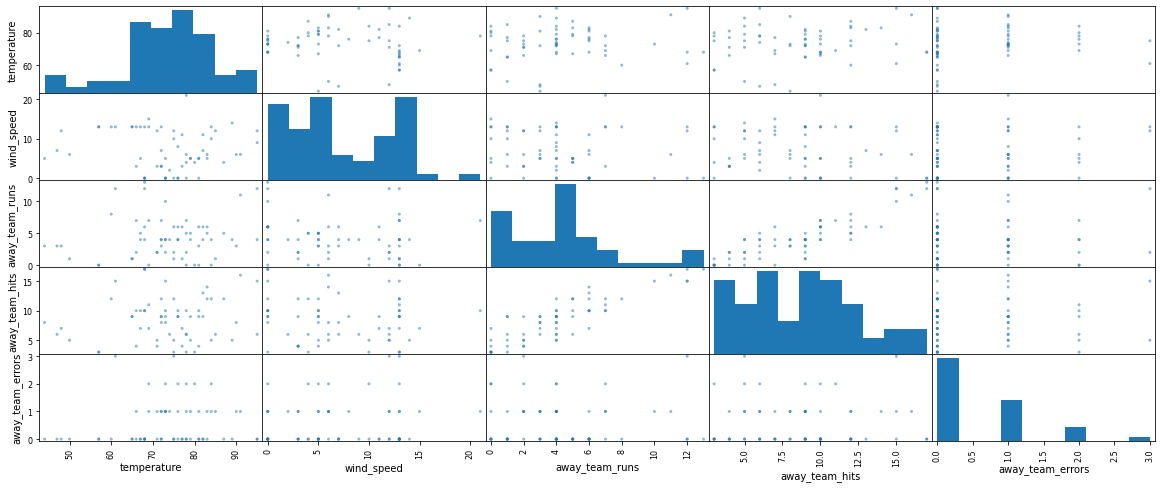

In [21]:
pd.plotting.scatter_matrix(rays_away_games[['temperature', 'wind_speed', 'away_team_runs', 'away_team_hits', 'away_team_errors']], figsize=(20, 8));

The data from this scatter matrix indicates that the relationship between the runs and hits of the way team relative to the wind speed and temperature is vague. While it is difficult to accurately observe the variable relationships from this scatter matrix, there are notable patterns such as the small similarities between temperature and away team hits. 

Note: There is no `away_team_win` field so we must calculate winrate inversely using 1 - mean `home_team_win`.

In [22]:
print(f"Win rate: {100 * (1-rays_away_games['home_team_win'].mean()) :.2f}%")

Win rate: 38.71%


### Rays (Home Games)

In [23]:
rays_home_games = team_games.query('home_team == "Tampa Bay Rays"')

In [24]:
print("Shape:", rays_home_games.shape)
rays_home_games.describe()

Shape: (84, 14)


,temperature,wind_speed,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team_hits,away_team_errors,away_team_runs,attendance
count,84.0,84.0,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,72.0,0.0,7.666667,0.523810,3.857143,0.452381,8.178571,0.535714,4.083333,16133.630952
std,0.0,0.0,3.167354,0.735931,2.949956,0.500717,3.289856,0.767509,2.854750,5817.233354
min,72.0,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,10117.000000
25%,72.0,0.0,6.000000,0.000000,2.000000,0.000000,6.000000,0.000000,2.000000,12203.250000
50%,72.0,0.0,7.000000,0.000000,3.000000,0.000000,8.000000,0.000000,3.500000,14186.500000
75%,72.0,0.0,9.000000,1.000000,5.000000,1.000000,10.000000,1.000000,6.000000,17901.750000
max,72.0,0.0,18.000000,3.000000,15.000000,1.000000,17.000000,3.000000,13.000000,40135.000000


Let us compare their home game stats to away:

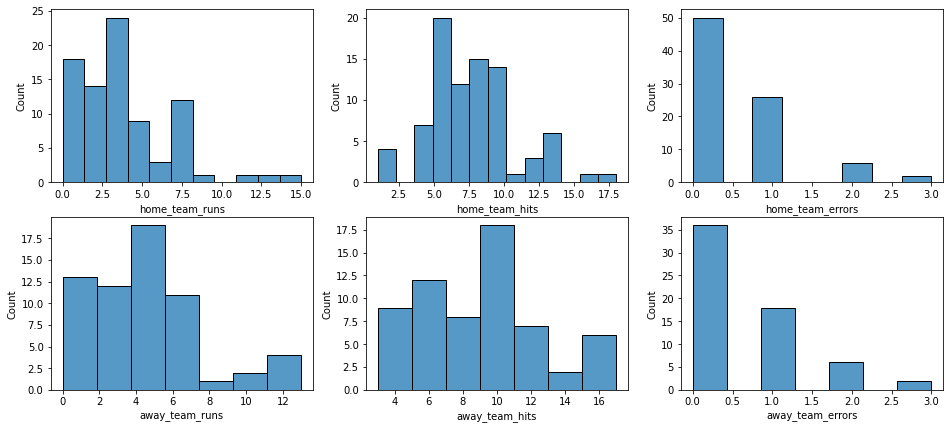

In [25]:
sns.histplot(rays_home_games, x='home_team_runs', ax=plt.subplot(231))
sns.histplot(rays_home_games, x='home_team_hits', ax=plt.subplot(232))
sns.histplot(rays_home_games, x='home_team_errors', ax=plt.subplot(233))

sns.histplot(rays_away_games, x='away_team_runs', ax=plt.subplot(234))
sns.histplot(rays_away_games, x='away_team_hits', ax=plt.subplot(235))
sns.histplot(rays_away_games, x='away_team_errors', ax=plt.subplot(236));

Looking at outliers & the range of values, it looks like at home, the Rays reach higher highs in runs and hits, but when playing away, they have more mean hits, errors, and runs (8.580645	0.580645	4.274194) compared to at home (7.666667	0.523810	3.857143).

Notice below: At home, the Rays play in the Tropicana Field dome that regulates weather conditions, so their varying performance should not relate to the weather.

In [26]:
rays_home_games.head()

,sky,temperature,wind_speed,wind_direction,home_team,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team,away_team_hits,away_team_errors,away_team_runs,attendance
0,In Dome,72.0,0.0,NA,Tampa Bay Rays,7,1,3,1,Toronto Blue Jays,9,0,2,12757.0
1,In Dome,72.0,0.0,NA,Tampa Bay Rays,8,0,3,1,Chicago White Sox,5,1,2,21810.0
2,In Dome,72.0,0.0,NA,Tampa Bay Rays,5,0,2,1,Baltimore Orioles,5,0,0,12996.0
3,In Dome,72.0,0.0,NA,Tampa Bay Rays,4,1,1,0,Toronto Blue Jays,5,0,5,27217.0
5,In Dome,72.0,0.0,NA,Tampa Bay Rays,5,0,3,0,Oakland Athletics,11,1,6,14604.0


In [27]:
print(f"Win rate: {rays_home_games['home_team_win'].mean()*100:.2f}%")

Win rate: 45.24%


Higher win rate at home though, 45.24% > 38.71%!

From the basic data we analyzed, it looks like the Rays have slightly better results at home compared to away. However, we cannot say that this is because of weather differences yet - we will have to look deeper using our play by play data later.

### White Sox (Away Games)



In [28]:
white_sox_away_games = team_games.query('away_team == "Chicago White Sox"')

In [29]:
print("Shape:", white_sox_away_games.shape)
white_sox_away_games.describe()

Shape: (72, 14)


,temperature,wind_speed,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team_hits,away_team_errors,away_team_runs,attendance
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,75.013889,7.319444,8.500000,0.527778,4.555556,0.569444,9.097222,0.569444,4.069444,27534.583333
std,9.256126,5.830533,3.576134,0.934054,3.322518,0.498629,3.162989,0.688464,2.718359,8016.995837
min,42.000000,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,10478.000000
25%,71.500000,1.000000,6.000000,0.000000,2.000000,0.000000,6.750000,0.000000,2.000000,21069.500000
50%,75.000000,7.000000,8.000000,0.000000,4.000000,1.000000,9.000000,0.000000,3.500000,28781.000000
75%,80.250000,12.250000,12.000000,1.000000,7.000000,1.000000,11.000000,1.000000,6.000000,34186.000000
max,94.000000,21.000000,17.000000,4.000000,13.000000,1.000000,17.000000,3.000000,11.000000,42031.000000


In [30]:
print(f"Win rate: {100 * (1-white_sox_away_games['home_team_win'].mean()) :.2f}%")

Win rate: 43.06%


### White Sox (Home Games)

In [31]:
white_sox_home_games = team_games.query('home_team == "Chicago White Sox"')

In [32]:
print("Shape:", white_sox_home_games.shape)
white_sox_home_games.describe()

Shape: (60, 14)


,temperature,wind_speed,home_team_hits,home_team_errors,home_team_runs,home_team_win,away_team_hits,away_team_errors,away_team_runs,attendance
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,59.000000
mean,73.900000,10.083333,8.833333,0.566667,4.216667,0.566667,8.616667,0.533333,3.966667,21701.016949
std,12.620537,3.618651,3.200459,0.830900,2.882393,0.499717,3.668887,0.947193,3.080649,6216.247378
min,32.000000,2.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,11418.000000
25%,65.750000,7.750000,6.000000,0.000000,2.000000,0.000000,6.000000,0.000000,2.000000,17863.000000
50%,76.000000,9.500000,9.000000,0.000000,4.000000,1.000000,8.000000,0.000000,3.000000,20653.000000
75%,84.000000,13.000000,11.000000,1.000000,7.000000,1.000000,11.000000,1.000000,6.000000,25690.500000
max,92.000000,17.000000,16.000000,3.000000,11.000000,1.000000,20.000000,4.000000,11.000000,39553.000000


Let us compare their home game stats to away:

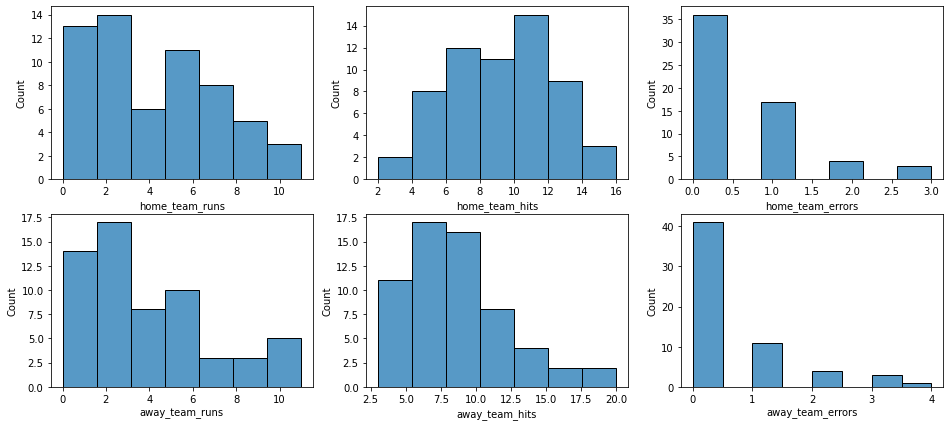

In [33]:
sns.histplot(white_sox_home_games, x='home_team_runs', ax=plt.subplot(231))
sns.histplot(white_sox_home_games, x='home_team_hits', ax=plt.subplot(232))
sns.histplot(white_sox_home_games, x='home_team_errors', ax=plt.subplot(233))

sns.histplot(white_sox_home_games, x='away_team_runs', ax=plt.subplot(234))
sns.histplot(white_sox_home_games, x='away_team_hits', ax=plt.subplot(235))
sns.histplot(white_sox_home_games, x='away_team_errors', ax=plt.subplot(236));

Hits | Errors | Runs  
Home: 8.833333	0.566667	4.216667	
Away: 9.097222	0.569444	4.069444  

The plots & stats suggest that there is no significant difference in the performance of the White Sox team resulting from playing on home territory vs. away territory. One small observable difference is that the White Sox have a slightly higher hitting average when playing away games, but this difference is negligible compared to the change noticed in the Rays.

In [34]:
print(f"Win rate: {white_sox_home_games['home_team_win'].mean()*100:.2f}%")

Win rate: 56.67%


While their performance is almost the same, the White Sox still have a 13% higher win rate at home.

## Play-by-play data

In [35]:
print("Shape:", clean_rays.shape)
clean_rays.head()

Shape: (43470, 25)


,index,awayTeamName,homeTeamName,hitterFirstName,hitterLastName,hitLocation,hitType,pitcherFirstName,pitcherLastName,pitchType,...,is_ab,is_ab_over,is_hit,is_on_base,is_bunt,is_bunt_shown,is_double_play,is_triple_play,is_wild_pitch,is_passed_ball
0,233,Rays,Royals,Taylor,Motter,0,NaN,Daniel,Duffy,CH,...,0,0,0,0,0,0,0,0,0,0
1,233,Rays,Royals,Omar,Infante,22,LD,Christopher,Archer,SL,...,1,1,0,0,0,0,0,0,0,0
2,233,Rays,Royals,Taylor,Motter,0,NaN,Wade,Davis,FA,...,0,0,0,0,0,0,0,0,0,0
3,233,Rays,Royals,Logan,Morrison,15,NaN,Daniel,Duffy,FA,...,1,1,1,1,0,0,0,0,0,0
4,233,Rays,Royals,Taylor,Motter,0,NaN,Daniel,Duffy,FA,...,0,0,0,0,0,0,0,0,0,0


In [36]:
print("Shape:", clean_white_sox.shape)
clean_white_sox.head()

Shape: (39151, 25)


,index,awayTeamName,homeTeamName,hitterFirstName,hitterLastName,hitLocation,hitType,pitcherFirstName,pitcherLastName,pitchType,...,is_ab,is_ab_over,is_hit,is_on_base,is_bunt,is_bunt_shown,is_double_play,is_triple_play,is_wild_pitch,is_passed_ball
0,169,White Sox,Royals,Todd,Frazier,0,NaN,Jason,Vargas,FA,...,0,0,0,0,0,0,0,0,0,0
1,169,White Sox,Royals,Adam,Eaton,0,NaN,Jason,Vargas,FA,...,0,0,0,0,0,0,0,0,0,0
2,169,White Sox,Royals,Todd,Frazier,11,FB,Dillon,Gee,CH,...,1,1,0,0,0,0,0,0,0,0
3,169,White Sox,Royals,Whitley,Merrifield,0,NaN,Miguel,Gonzalez,FA,...,0,0,0,0,0,0,0,0,0,0
4,169,White Sox,Royals,Cheslor,Cuthbert,0,NaN,Miguel,Gonzalez,FA,...,0,0,0,0,0,0,0,0,0,0


In [37]:
clean_rays.describe()

,index,hitLocation,pitchZone,pitchSpeed,is_ab,is_ab_over,is_hit,is_on_base,is_bunt,is_bunt_shown,is_double_play,is_triple_play,is_wild_pitch,is_passed_ball
count,43470.000000,43470.000000,43470.000000,43470.000000,43470.000000,43470.000000,43470.000000,43470.000000,43470.000000,43470.000000,43470.000000,43470.0,43470.000000,43470.000000
mean,126.107591,2.828571,8.267495,83.558730,0.218473,0.241684,0.054014,0.067909,0.004348,0.003589,0.004647,0.0,0.002646,0.000529
std,78.830427,7.057698,4.043728,20.367705,0.413214,0.428109,0.226048,0.251592,0.065795,0.059799,0.068010,0.0,0.051367,0.022996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,56.000000,0.000000,5.000000,84.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,122.000000,0.000000,10.000000,89.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,194.000000,0.000000,12.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,264.000000,35.000000,13.000000,102.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


We want to use this play-by-play data to take a closer look at how weather conditions are affecting plays in the games. Looking at the columns we have below, pitch speeds are going to be our natural choice of examination.

In [38]:
clean_rays.columns

Index(['index', 'awayTeamName', 'homeTeamName', 'hitterFirstName',
       'hitterLastName', 'hitLocation', 'hitType', 'pitcherFirstName',
       'pitcherLastName', 'pitchType', 'pitchTypeDescription', 'pitchZone',
       'pitchSpeed', 'outcomeDescription', 'venueName', 'is_ab', 'is_ab_over',
       'is_hit', 'is_on_base', 'is_bunt', 'is_bunt_shown', 'is_double_play',
       'is_triple_play', 'is_wild_pitch', 'is_passed_ball'],
      dtype='object')

### Separate the dataframes by each team's three pitchers with the most playing time to analyze their pitch speeds


In [39]:
rays_sps = clean_rays.loc[clean_rays['pitcherLastName'].isin(['Archer', 'Odorizzi', 'Smyly'])]
rays_sps.head()

,index,awayTeamName,homeTeamName,hitterFirstName,hitterLastName,hitLocation,hitType,pitcherFirstName,pitcherLastName,pitchType,...,is_ab,is_ab_over,is_hit,is_on_base,is_bunt,is_bunt_shown,is_double_play,is_triple_play,is_wild_pitch,is_passed_ball
1,233,Rays,Royals,Omar,Infante,22,LD,Christopher,Archer,SL,...,1,1,0,0,0,0,0,0,0,0
5,233,Rays,Royals,Whitley,Merrifield,0,NaN,Christopher,Archer,SL,...,0,0,0,0,0,0,0,0,0,0
7,233,Rays,Royals,Eric,Hosmer,0,NaN,Christopher,Archer,CH,...,0,0,0,0,0,0,0,0,0,0
9,233,Rays,Royals,Andrew,Butera,16,NaN,Christopher,Archer,CH,...,1,1,1,1,0,0,0,0,0,0
10,233,Rays,Royals,Andrew,Butera,0,NaN,Christopher,Archer,FA,...,0,0,0,0,0,0,0,0,0,0


In [40]:
white_sox_sps = clean_white_sox.loc[clean_white_sox['pitcherLastName'].isin(['Sale', 'Quintana', 'Rodon'])]
white_sox_sps.head()

,index,awayTeamName,homeTeamName,hitterFirstName,hitterLastName,hitLocation,hitType,pitcherFirstName,pitcherLastName,pitchType,...,is_ab,is_ab_over,is_hit,is_on_base,is_bunt,is_bunt_shown,is_double_play,is_triple_play,is_wild_pitch,is_passed_ball
112,167,White Sox,Royals,Kendrys,Morales,0,NaN,Carlos,Rodon,FA,...,0,0,0,0,0,0,0,0,0,0
115,167,White Sox,Royals,Paulo,Orlando,0,NaN,Carlos,Rodon,SL,...,0,0,0,0,0,0,0,0,0,0
116,167,White Sox,Royals,Christian,Colon,0,NaN,Carlos,Rodon,SL,...,0,0,0,0,0,0,0,0,0,0
121,167,White Sox,Royals,Alcides,Escobar,0,NaN,Carlos,Rodon,FA,...,0,0,0,0,0,0,0,0,0,0
126,167,White Sox,Royals,Alcides,Escobar,0,NaN,Carlos,Rodon,CH,...,0,0,0,0,0,0,0,0,0,0


### Adding temperature data to these dataframes

Temperature will be our main indicator for variance in playing conditions, so let's add temperature values to the plays.

In [41]:
def addTemp(row):
  """Adds a temperature value to a row via the `index` field."""
  index = row['index']
  row['temperature'] = team_games.iloc[index]['temperature']
  return row

rays_sps = rays_sps.apply(addTemp, axis=1)
white_sox_sps = white_sox_sps.apply(addTemp, axis=1)

In [42]:
rays_sps['pitchType'].unique()

array(['SL', 'CH', 'FA', nan, 'SP', 'CU', 'CT', 'PI', 'IB'], dtype=object)

### Separating by pitcher to analyze each pitcher separately

We can take a detailed look at performance by examining and visualizing individual data from the pitchers we chose.

In [43]:
def get_pitches(df, lastName):
  """Gets pitches from a specified pitcher."""
  return df[df['pitcherLastName'] == lastName]

rodon_ws_pitches = get_pitches(white_sox_sps, 'Rodon')
sale_ws_pitches = get_pitches(white_sox_sps, 'Sale')
quintana_ws_pitches = get_pitches(white_sox_sps, 'Quintana')

archer_rays_pitches = get_pitches(rays_sps, 'Archer')
odorizzi_rays_pitches = get_pitches(rays_sps, 'Odorizzi')
smyly_rays_pitches = get_pitches(rays_sps, 'Smyly')

In [44]:
def clean_pitches(df, toDrop):
  """Drop NA pitches & certain pitch types."""
  df.dropna(subset=['pitchType'], inplace=True)
  for varName, valuesToDrop in toDrop.items():
    for value in valuesToDrop:
      df.drop(df[ df[varName] == value ].index, inplace=True)

# Drop Intentional Balls
clean_pitches(rodon_ws_pitches, {'pitchType': ['IB']})
clean_pitches(sale_ws_pitches, {'pitchType': ['IB']})
clean_pitches(quintana_ws_pitches, {'pitchType': ['IB']})

clean_pitches(archer_rays_pitches, {'pitchType': ['IB']})
clean_pitches(odorizzi_rays_pitches, {'pitchType': ['IB']})
clean_pitches(smyly_rays_pitches, {'pitchType': ['IB']})

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now, we want to observe pitch speeds across varying temperatures.

In [45]:
rodon_temps = rodon_ws_pitches['temperature'].unique()
rodon_temps.sort()

print("Temperatures in Rodon's pitches:", rodon_temps)
print("Rodon's pitch types:", rodon_ws_pitches['pitchType'].unique())

Temperatures in Rodon's pitches: [52. 55. 63. 68. 70. 72. 74. 75. 78. 79. 80. 82. 83. 85. 86. 88.]
Rodon's pitch types: ['FA' 'SL' 'CH' 'CU' 'SI']


Pitch types values include Fastball, Slider, Changeup, Splitter, Curveball, Cutter, Other, Pitchout, Intentional Ball, nan

In [46]:
def getAvgsPerTemp(pitches):
  """Return a temp x pitch speed dataframe for a pitcher's pitches."""
  pitchTypes = pitches['pitchType'].unique()
  temps = pitches['temperature'].unique()
  temps.sort()

  df = pd.DataFrame()
  df['temperature'] = temps

  for pitchType in pitchTypes:
    plays = pitches[pitches['pitchType'] == pitchType]
    means = []
    counts = []
    for i, row in df.iterrows():
      plays_with_temp = plays[plays['temperature'] == row['temperature']]
      means.append(np.mean(plays_with_temp['pitchSpeed']))
      counts.append(len(plays_with_temp))
    
    df[f'{pitchType} mean'] = means
    df[f'{pitchType} count'] = counts

  return df

In [47]:
rodon_ws_avgs = getAvgsPerTemp(rodon_ws_pitches)
sale_ws_avgs = getAvgsPerTemp(sale_ws_pitches)
quintana_ws_avgs = getAvgsPerTemp(quintana_ws_pitches)

archer_rays_avgs = getAvgsPerTemp(archer_rays_pitches)
odorizzi_rays_avgs = getAvgsPerTemp(odorizzi_rays_pitches)
smyly_rays_avgs = getAvgsPerTemp(smyly_rays_pitches)

rodon_ws_avgs

,temperature,FA mean,FA count,SL mean,SL count,CH mean,CH count,CU mean,CU count,SI mean,SI count
0,52.0,92.446154,130,84.968254,63,82.941176,17,NaN,0,NaN,0
1,55.0,91.643836,73,84.833333,18,84.600000,5,80.0,1,NaN,0
2,63.0,95.389831,59,88.500000,22,84.857143,14,NaN,0,NaN,0
3,68.0,91.961538,78,84.260870,23,81.000000,2,NaN,0,NaN,0
4,70.0,93.376812,69,87.103448,29,83.800000,10,NaN,0,NaN,0
5,72.0,93.788991,109,86.862745,51,84.238095,21,NaN,0,NaN,0
6,74.0,93.833333,72,86.343750,32,81.000000,1,NaN,0,NaN,0
7,75.0,94.426471,68,87.437500,32,85.187500,16,NaN,0,NaN,0
8,78.0,92.908046,87,86.541667,24,83.166667,12,NaN,0,NaN,0
9,79.0,93.432203,118,87.187500,48,83.571429,35,NaN,0,NaN,0


As Fastballs are fairly common, we will graph these speeds among the pitchers.

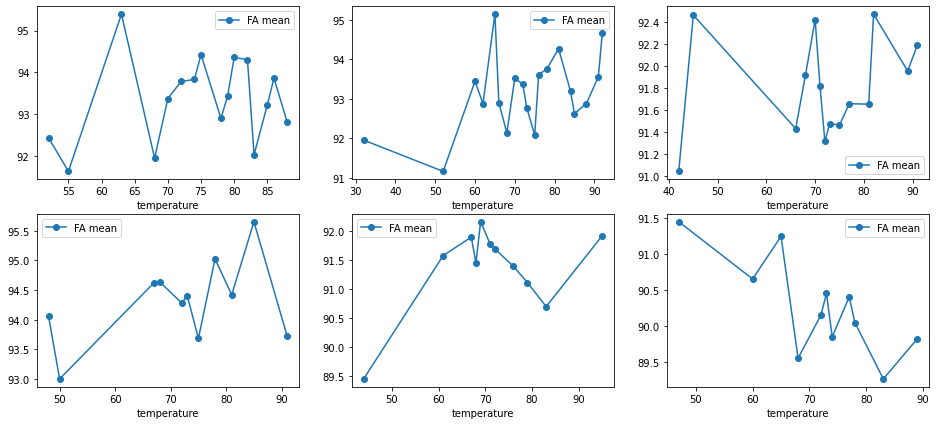

In [48]:
rodon_ws_avgs.plot(x='temperature', y='FA mean', marker='o', ax=plt.subplot(231))
sale_ws_avgs.plot(x='temperature', y='FA mean', marker='o', ax=plt.subplot(232))
quintana_ws_avgs.plot(x='temperature', y='FA mean', marker='o', ax=plt.subplot(233))

archer_rays_avgs.plot(x='temperature', y='FA mean', marker='o', ax=plt.subplot(234))
odorizzi_rays_avgs.plot(x='temperature', y='FA mean', marker='o', ax=plt.subplot(235))
smyly_rays_avgs.plot(x='temperature', y='FA mean', marker='o', ax=plt.subplot(236));

The top row are the White Sox pitcher averages & the bottom row are the Rays pitcher averages.  
The y-axis (FA mean) is the mean speed for their fastballs.  

When observing the performance of pitching speed for the White Sox, the correlation between temperature and ball speed is more vague, shown by their speeds zigzagging around the middle for the most part. This indicates that the White Sox pitchers are less affected by temperature than the Rays pitchers, who contrastly show significant changes between pitching speed and temperature as seen in all three graphs. While the effect of temperature on the Rays pitching is not consistent, we still observe noticeable differences as temperature increases.